This workbook is an analysis of the "World Development Indicators" Dataset from the world bank. The link to the files can be found [here](https://datacatalog.worldbank.org/dataset/world-development-indicators).

The main question that I would like to answer about the data is:

>How does the development of infrastructure (measured by access to electricity, GDP, and the number of health workers per capita), impact the mortality rate in the country?

With my hypotheses being:

>GDP, access to electricity (by % of the overall population), and the number of health workers per capital will have a positive correlation with life expectancy.

With the null hypothesis being: 

>there is no difference based on these factors.

The main purpose of this project is to draw informed conclusions about the impact of these indicators on life expectancy, to hopefully provide a guideline on what sectors developing countries should focus on improving first to benefit their population.



The general trend that this analysis will follow is:
* Aquire the data and wrangle it into a manageable form.
* Analyze the overall trends across all of the years.
* Focus on individual years to form a holistic view of how these indicators change and interact over time.
* Restate the important points and takeaways

In [ ]:
#To keep the page organized do all imports here, not all things imported will be
#used due to coding revisions.

#Secondary note: most of the outputs to dataframe building have been deleted
#so as to avoid excessive text in the workbook, although all code has been run 
#and verified.
from sqlalchemy import create_engine
from scipy import stats
import warnings
import pandas as pd
import seaborn as sns 
import requests
from io import StringIO
import zipfile
import gzip
import numpy as np
import seaborn as sns
sns.set()
import glob
import os
import json
from pandas.io.json import json_normalize 
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initially, the data was accessible via API requests or downloadable .zip files. Rather than going through the hassle of working with API queries, I downloaded and re-uploaded the dataset from the .zip file that I needed, which is the link you'll see in the cell below.

In [ ]:
#Here we fetch the data and convert it to a dataframe for analysis
df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/WDIData.csv')

#While we're at it, lets retrieve some basic information about the data, 
#as well as the first few rows to see what we're working with.
df.info()
df.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379368 entries, 0 to 379367
Data columns (total 66 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    379368 non-null  object 
 1   Country Code    379368 non-null  object 
 2   Indicator Name  379368 non-null  object 
 3   Indicator Code  379368 non-null  object 
 4   1960            37734 non-null   float64
 5   1961            42123 non-null   float64
 6   1962            44349 non-null   float64
 7   1963            44232 non-null   float64
 8   1964            44795 non-null   float64
 9   1965            47322 non-null   float64
 10  1966            47032 non-null   float64
 11  1967            48769 non-null   float64
 12  1968            48350 non-null   float64
 13  1969            50261 non-null   float64
 14  1970            71053 non-null   float64
 15  1971            77338 non-null   float64
 16  1972            80127 non-null   float64
 17  1973      

<bound method NDFrame.head of        Country Name Country Code  ... 2020 Unnamed: 65
0        Arab World          ARB  ...  NaN         NaN
1        Arab World          ARB  ...  NaN         NaN
2        Arab World          ARB  ...  NaN         NaN
3        Arab World          ARB  ...  NaN         NaN
4        Arab World          ARB  ...  NaN         NaN
...             ...          ...  ...  ...         ...
379363     Zimbabwe          ZWE  ...  NaN         NaN
379364     Zimbabwe          ZWE  ...  NaN         NaN
379365     Zimbabwe          ZWE  ...  NaN         NaN
379366     Zimbabwe          ZWE  ...  NaN         NaN
379367     Zimbabwe          ZWE  ...  NaN         NaN

[379368 rows x 66 columns]>

Now that we've formed our main dataframe, we can begin to filter out and format our values into usable formats.

In [ ]:
#Now, we will begin sorting the variables we want to use
#into separate dataframes, so we can analyze them.
electricity_df = df[df['Indicator Code'] == 'EG.ELC.ACCS.ZS']
gdp_df = df[df['Indicator Code'] == 'NY.GDP.MKTP.KD']
health_worker_df = df[df['Indicator Code'] == 'SH.MED.CMHW.P3']
life_expectancy_df = df[df['Indicator Code'] == 'SP.DYN.LE00.IN']

In [ ]:
#Let's check to make sure it formed all of the dataframes correctly.
electricity_df.info()
gdp_df.info()
health_worker_df.info()
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 1 to 377932
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            0 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      

As we can see from the above, there are quite a few null values, let's fix that by dropping them.

In [ ]:
#Here we just drop all of the NA columns
electricity_df = electricity_df.dropna(1,'all')
gdp_df = gdp_df.dropna(1,'all')
health_worker_df = health_worker_df.dropna(1,'all')
life_expectancy_df = life_expectancy_df.dropna(1,'all')

#Once again, let's check the info of our dataframes to verify that the commands worked
electricity_df.info()
gdp_df.info()
health_worker_df.info()
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 1 to 377932
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1990            82 non-null     float64
 5   1991            93 non-null     float64
 6   1992            108 non-null    float64
 7   1993            118 non-null    float64
 8   1994            123 non-null    float64
 9   1995            130 non-null    float64
 10  1996            139 non-null    float64
 11  1997            145 non-null    float64
 12  1998            150 non-null    float64
 13  1999            156 non-null    float64
 14  2000            174 non-null    float64
 15  2001            183 non-null    float64
 16  2002            191 non-null    float64
 17  2003            191 non-null    

Now, we need to set up a way to easily create dataframes from individual years. We'll do this by creating a function 'yeardata' that will pull yearly information for us and organize it into a datframe.

In [ ]:
#Here we are going to create a function that will take a year as text and create a dataframe of all the relavent data from that year in each category
def convert_to_list(dataframe):  #this function helps us convert dataframes into lists
  converted = []
  for line in dataframe:
    converted.append(line)
  return converted

def yeardata(year): #here we extract the dataframe information into lists, and then form a new dataframe for an individual year
  electricity = convert_to_list(electricity_df[year])
  gdp = convert_to_list(gdp_df[year])
  health = convert_to_list(health_worker_df[year])
  life = convert_to_list(life_expectancy_df[year])
  country = convert_to_list(gdp_df['Country Name'])
  dictionary = {'Country' : country,
                'Electricity': electricity,
                'GDP' : gdp,
                'Health' : health,
                'Life' : life}
  year_df = pd.DataFrame.from_dict(dictionary)
  return year_df


Now that that's finished, before we can get to analyzing yearly data, we'll create a dataframe that has the data for all of the indicators we are interested in, for every year that we have data for all 4 indicators.

In [ ]:
#First, lets take a look at the overall spread of the data across all years, and
#then begin breaking it down into smaller chunks.
years = []
for item in electricity_df.columns:
  #validate the column name, to make sure we only add years to our list
  if item != 'Country Name' and item != 'Country Code' and item != 'Indicator Name' and item != 'Indicator Code':
    years.append(item)
print(years)

['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


In [ ]:
#Here we create an empty dataframe so that we can begin to populate it with 
#our data spread across the years that we have data for in each dataframe.
all_years_df = pd.DataFrame(columns = ['Country', 'Electricity', 'GDP', 'Health', 'Life'])

#Let's also create a list of the years added, which we'll refer to as 'valid_years'
valid_years = []

#Now, we validate our list of 'years' to make sure all of the dataframes
#share the data we will be pulling for those years. 
for year in years:
  if (year in electricity_df.columns) and (year in gdp_df.columns) and (year in health_worker_df.columns) and (year in life_expectancy_df.columns):  
    all_years_df = all_years_df.append(yeardata(year))
    valid_years.append(year)
    

#Lastly, we check to make sure that the dataframe was created correctly.
all_years_df.info()
print('The valid years are: {}'.format(valid_years))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7128 entries, 0 to 263
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      7128 non-null   object 
 1   Electricity  4704 non-null   float64
 2   GDP          6429 non-null   float64
 3   Health       212 non-null    float64
 4   Life         6627 non-null   float64
dtypes: float64(4), object(1)
memory usage: 334.1+ KB
The valid years are: ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


In [ ]:
#Here we just check the number of years that we have data for. This isn't immediately important, but we'll use that number later. 
print(len(valid_years))

27


Now that we have everything prepared, we can begin to analyze our data. We'll start by creating distribution graphs for each indicator in our 'all_years_df' to get an idea for what our data looks like. 

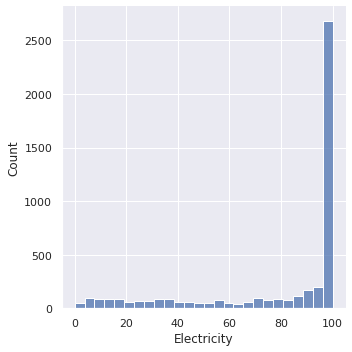

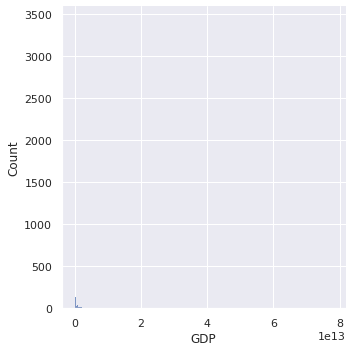

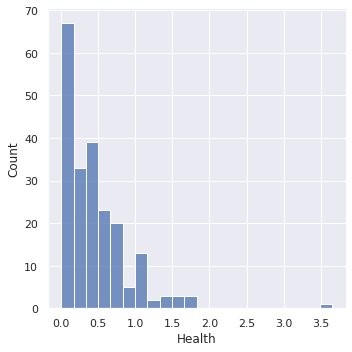

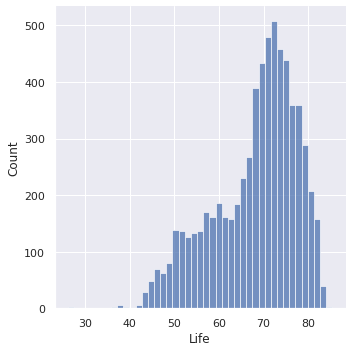

In [ ]:
sns.displot(all_years_df['Electricity'])
sns.displot(all_years_df['GDP'],)
sns.displot(all_years_df['Health'])
sns.displot(all_years_df['Life'])

The above are distribution graphs. Now, we will move into plotting the variables against one another in a scatterplot format.

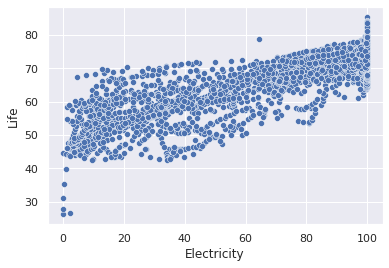

In [ ]:
sns.scatterplot(x='Electricity', y='Life', data=all_years_df)

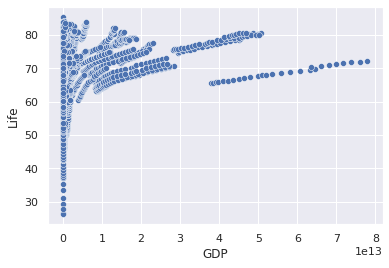

In [ ]:
sns.scatterplot(x='GDP', y='Life', data=all_years_df)

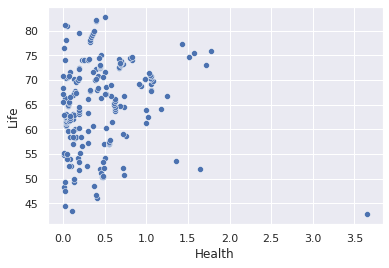

In [ ]:
sns.scatterplot(x='Health', y='Life', data=all_years_df)

Keep in mind that the above graphs include multiple records for some countries because they cover data from multiple years. This is just to get a feel for the sorts of distributions we'll see.

In [ ]:
test_df = all_years_df.sort_values(by=['Life'],ascending=True,)
test_df.head()

,Country,Electricity,GDP,Health,Life
209,Rwanda,0.010000,2.631404e+09,NaN,26.172
209,Rwanda,2.300000,2.863605e+09,NaN,26.691
209,Rwanda,0.010000,1.309174e+09,NaN,27.738
209,Rwanda,NaN,2.704761e+09,NaN,29.248
209,Rwanda,0.075259,1.770319e+09,NaN,31.037


In [ ]:
all_years_df_corr = all_years_df.dropna(axis=0,how='any')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(all_years_df_corr)

                            Country  Electricity           GDP  Health  \
87                            Chile    94.560057  9.438933e+10   0.021   
57                        Australia   100.000000  7.151577e+11   0.039   
72                         Botswana    23.115320  7.656466e+09   0.442   
121                           Ghana    42.600000  1.696701e+10   0.488   
125                         Grenada    85.040000  5.763953e+08   0.395   
196                        Pakistan    70.460000  1.080293e+11   0.038   
72                         Botswana    25.199066  8.396635e+09   0.454   
121                           Ghana    42.504211  1.771356e+10   0.556   
125                         Grenada    85.526489  6.161571e+08   0.444   
196                        Pakistan    70.297935  1.119833e+11   0.039   
72                         Botswana    27.277466  8.563535e+09   0.731   
88                            China    96.907104  2.232146e+12   1.033   
109                         Estonia   

Next, we'll begin running correlation tests on the aggregated data to look for any form of pattern.

In [ ]:
#we'll be making 3 dataframes total, all using the same method. The purpose here
#is to isolate the variables that we want to use, so that we only have to eliminate
#NaN values from relavent data, allowing us to keep as much information as possible.

#First, we extract the columns that we want from the 'all_years_df' dataframe, and 
#then we drop all of the 'NaN' values so that we can run the stats.pearonr command.
elec_life_overall_df = all_years_df.filter(['Country','Electricity','Life'])
elec_life_overall_df = elec_life_overall_df.dropna(axis=0,how='any')

gdp_life_overall_df = all_years_df.filter(['Country','GDP','Life'])
gdp_life_overall_df = gdp_life_overall_df.dropna(axis=0,how='any')

health_life_overall_df = all_years_df.filter(['Country','Health','Life'])
health_life_overall_df = health_life_overall_df.dropna(axis=0,how='any')

In [ ]:
stats.pearsonr(elec_life_overall_df['Electricity'], elec_life_overall_df['Life'])

(0.8637829017517007, 0.0)

In [ ]:
stats.pearsonr(gdp_life_overall_df['GDP'], gdp_life_overall_df['Life'])

(0.17107886267814867, 1.3242036691805675e-41)

In [ ]:
stats.pearsonr(health_life_overall_df['Health'], health_life_overall_df['Life'])

(0.08379920081941179, 0.23810059379942503)

From these Pearson correlation tests, we can see that there is a strong chance that there is a positive correlation between both the "Electricity" and the "GDP" variables, with a country's life expectancy. This is to say that the higher each of those values are, the more likely it is that we will see an increased life expectancy.

However, in contrast, we see little evidence of any correlation between the "Health" value with the life expectancy. This suggests that the number of health workers per capita is more or less irrelevant with regards to life expectancy. 

Next, we'll begin breaking down the data by each year to examine yearly trends, as well as take a look at the data without repeat values for countries. The first question we need to answer, however, is "which years do we want to use?". We have usable data for 27 separate years, and examining each of them individually would be time-consuming, and unhelpful. Instead, we'll grab data for 4 separate years, starting with 1990 (the oldest year available), then skip ahead to 2000, and then 2010, ending with the year 2016 (the most recent year available). This should give us a good view of the overall data trends as time goes on.

In [ ]:
nineteen_ninety_df = yeardata('1990')
nineteen_ninety_df.info()

twothousand_df = yeardata('2000')
twothousand_df.info()

twothousand_ten_df = yeardata('2010')
twothousand_ten_df.info()

twothousand_sixteen_df = yeardata('2016')
twothousand_sixteen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      264 non-null    object 
 1   Electricity  82 non-null     float64
 2   GDP          215 non-null    float64
 3   Health       6 non-null      float64
 4   Life         243 non-null    float64
dtypes: float64(4), object(1)
memory usage: 10.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      264 non-null    object 
 1   Electricity  174 non-null    float64
 2   GDP          239 non-null    float64
 3   Health       11 non-null     float64
 4   Life         247 non-null    float64
dtypes: float64(4), object(1)
memory usage: 10.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 5 colu

From the summaries of the dataframes, the first thing that stands out is the apparent increase in reporting in certain areas as time moves forward. This likely has a lot to do with the rise of technology and the information era in those years. 

# 1990 Year Data

In [ ]:
nineteen_ninety_df.describe()

,Electricity,GDP,Health,Life
count,82.000000,2.150000e+02,6.000000,243.000000
mean,94.949470,1.359874e+12,0.646807,64.719593
std,16.223528,4.675286e+12,0.464711,9.505259
min,13.900000,2.144197e+07,0.140921,33.413000
25%,100.000000,4.757358e+09,0.209691,58.122400
50%,100.000000,2.627304e+10,0.738500,67.860414
75%,100.000000,3.647493e+11,1.061000,71.557000
max,100.000000,3.790534e+13,1.061000,78.836829


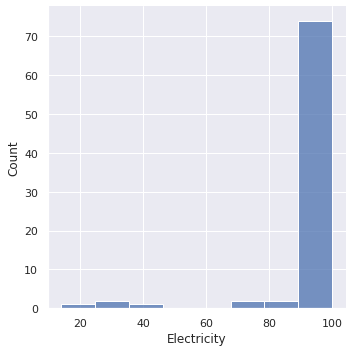

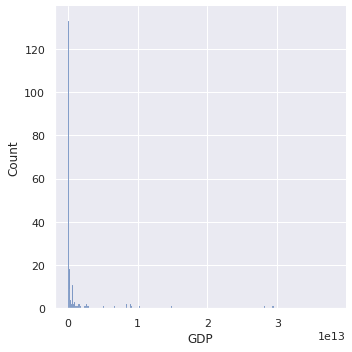

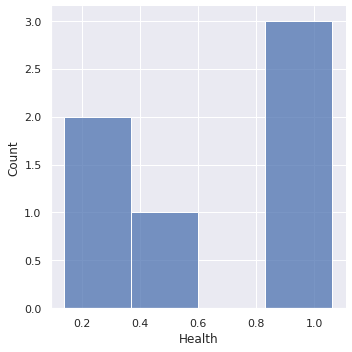

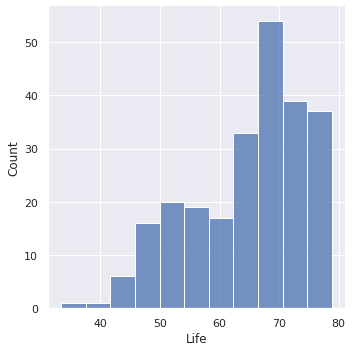

In [ ]:
sns.displot(data=nineteen_ninety_df['Electricity'])
sns.displot(data=nineteen_ninety_df['GDP'])
sns.displot(data=nineteen_ninety_df['Health'])
sns.displot(data=nineteen_ninety_df['Life'])

The first things we see from the distrubution graphs in 1990:

* Most countries had high levels of access to electricity for their population. 
* Most countries have lower GDPs compared to a few extremely wealthy outliers.
* Health worker data is under-reported.
* Life expectency has a large distrubution, but is mostly above 60 years. 

# 2000 Year Data

In [ ]:
twothousand_df.describe()

,Electricity,GDP,Health,Life
count,174.000000,2.390000e+02,11.000000,247.000000
mean,76.203413,1.615008e+12,0.522044,66.761755
std,33.132662,5.816281e+12,0.380497,9.776774
min,2.704968,2.900917e+07,0.031000,39.441000
25%,57.080936,5.303881e+09,0.238000,60.154133
50%,97.800000,2.988343e+10,0.460000,69.667000
75%,100.000000,3.873691e+11,0.858872,73.863500
max,100.000000,4.994090e+13,1.033000,81.076098


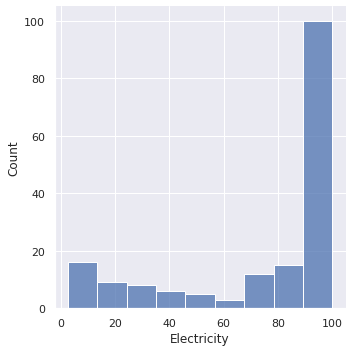

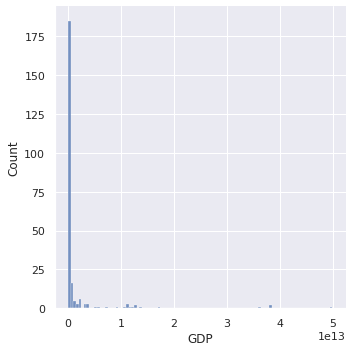

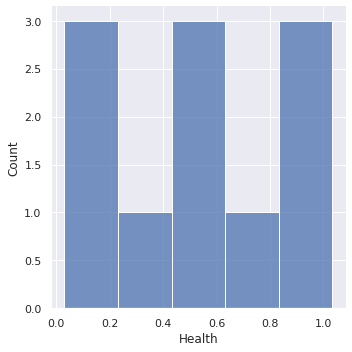

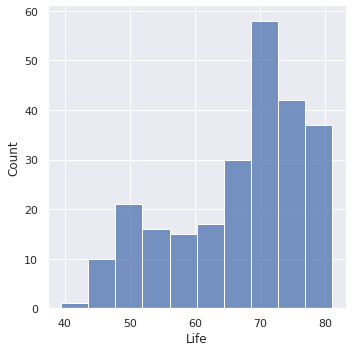

In [ ]:
sns.displot(data= twothousand_df['Electricity'])
sns.displot(data= twothousand_df['GDP'], bins=100)
sns.displot(data= twothousand_df['Health'])
sns.displot(data= twothousand_df['Life'])

When looking at the data for the year 2000, we have a much more holistic look at what is going on with the data, because of more countries reporting their information. This begins to paint a clearer picture of some of our metrics. For example, we see that:
* Fewer countries have widespread access to electricity than we thought.
* The GDP graph is still unclear and will require some tweaking later on.
* Health worker data appears to be underreported, and also has no visible trends.

# 2010 Year Data

In [ ]:
twothousand_ten_df.describe()

,Electricity,GDP,Health,Life
count,213.000000,2.520000e+02,13.000000,246.000000
mean,79.774909,2.117374e+12,0.351154,70.179859
std,30.156718,7.297244e+12,0.493940,8.537251
min,1.500000,3.182352e+07,0.001000,45.100000
25%,64.350000,6.933109e+09,0.061000,64.547637
50%,98.864006,4.081125e+10,0.161000,72.051500
75%,100.000000,4.823030e+11,0.435000,76.008421
max,100.000000,6.611312e+13,1.777000,82.978049


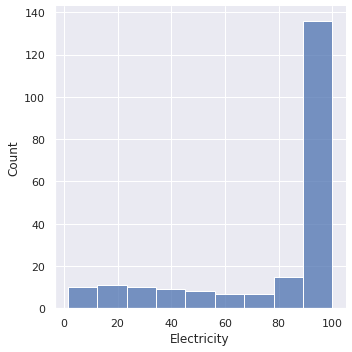

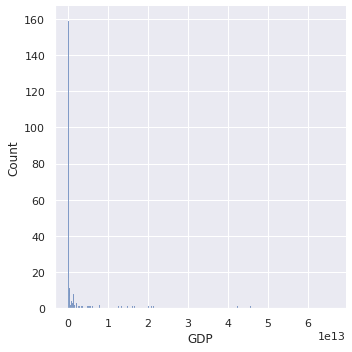

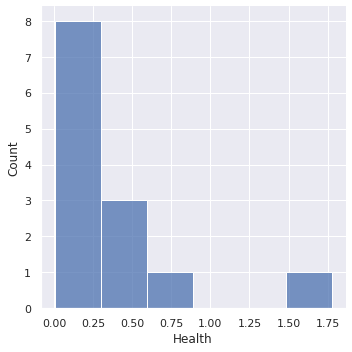

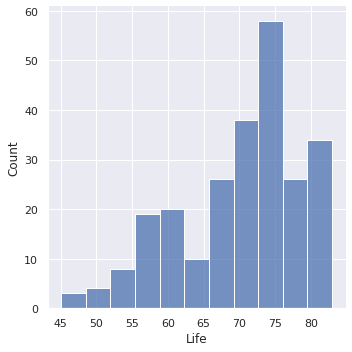

In [ ]:
sns.displot(data= twothousand_ten_df['Electricity'])
sns.displot(data= twothousand_ten_df['GDP'])
sns.displot(data= twothousand_ten_df['Health'])
sns.displot(data= twothousand_ten_df['Life'])

Here, we see the data following the expected trend for electricity and life expectancy, a slow overall increase. As we covered earlier, there is likely a strong correlation between access to electricity and life expectancy.

# 2016 Year Data

In [ ]:
twothousand_sixteen_df.describe()

,Electricity,GDP,Health,Life
count,215.000000,2.440000e+02,6.000000,247.000000
mean,84.812926,2.625478e+12,0.331500,72.094990
std,25.475218,8.681360e+12,0.246993,7.497675
min,9.637500,3.921611e+07,0.000000,51.593000
25%,76.760311,1.094002e+10,0.131500,67.323000
50%,99.921829,5.229079e+10,0.411000,73.395956
75%,100.000000,5.912976e+11,0.513500,77.484000
max,100.000000,7.790414e+13,0.581000,84.226829


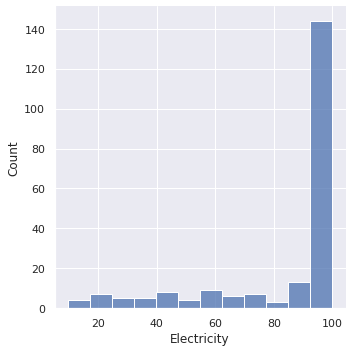

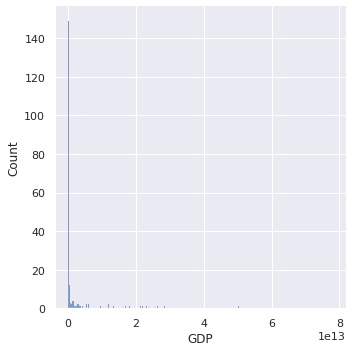

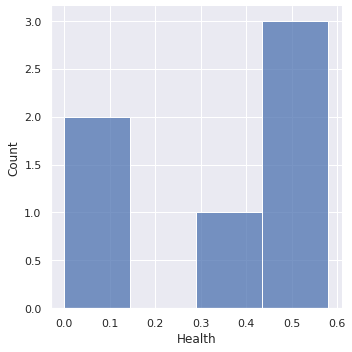

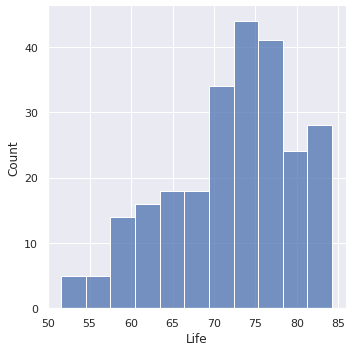

In [ ]:
sns.displot(data= twothousand_sixteen_df['Electricity'])
sns.displot(data= twothousand_sixteen_df['GDP'])
sns.displot(data= twothousand_sixteen_df['Health'])
sns.displot(data= twothousand_sixteen_df['Life'])

Once again, moving into the most recent year of our data, we see the expected increase in life expectancy and access to electricity. 

# Relationship Between Electricity and Life Expectancy

(0.0, 100.0)

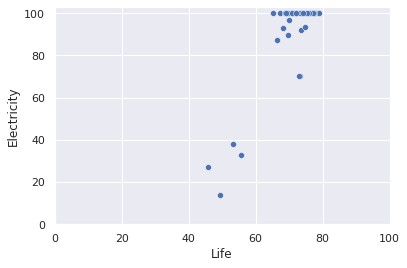

In [ ]:
sns.scatterplot(x='Life', y='Electricity', data= nineteen_ninety_df)
plt.ylim(0, 103)
plt.xlim(0, 100)

(0.0, 100.0)

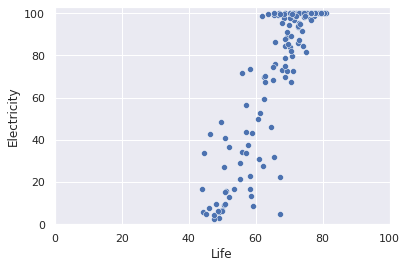

In [ ]:
sns.scatterplot(x='Life', y='Electricity', data= twothousand_df)
plt.ylim(0, 103)
plt.xlim(0, 100)

(0.0, 100.0)

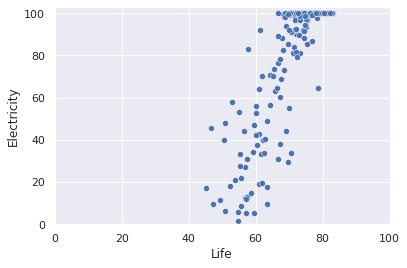

In [ ]:
sns.scatterplot(x='Life', y='Electricity', data= twothousand_ten_df)
plt.ylim(0, 103)
plt.xlim(0, 100)

(0.0, 100.0)

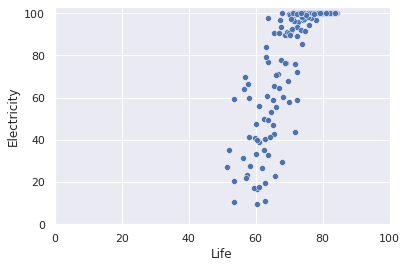

In [ ]:
sns.scatterplot(x='Life', y='Electricity', data= twothousand_sixteen_df)
plt.ylim(0, 103)
plt.xlim(0, 100)

# Relationship Between GDP and Life Expectancy

In this section, there will be graphs of the overall GDP and life expectancy correlation, followed by graphs of the same data, but zoomed in on the lower data points to get a clearer look at trends

Data for 1990

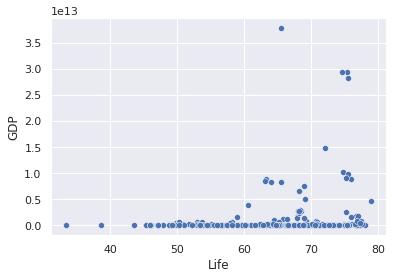

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= nineteen_ninety_df)

(0.0, 100.0)

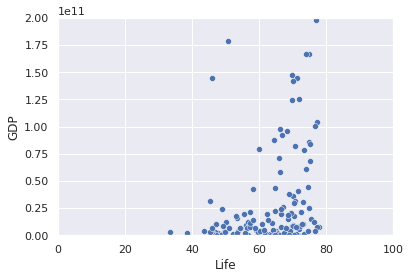

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= nineteen_ninety_df)
plt.ylim(0, 200000000000)
plt.xlim(0, 100)

Data for 2000

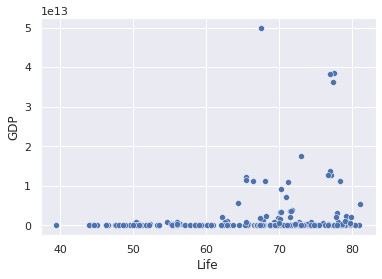

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= twothousand_df)

(0.0, 100.0)

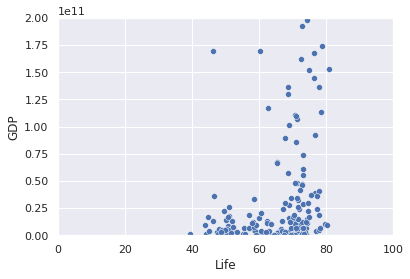

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= twothousand_df)
plt.ylim(0, 200000000000)
plt.xlim(0, 100)

Data for 2010

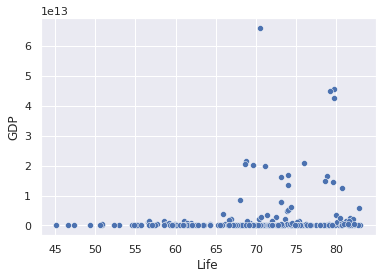

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= twothousand_ten_df)

(0.0, 100.0)

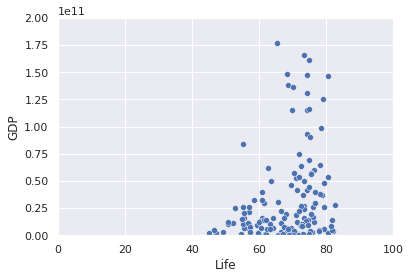

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= twothousand_ten_df)
plt.ylim(0, 200000000000)
plt.xlim(0, 100)

Data for 2016

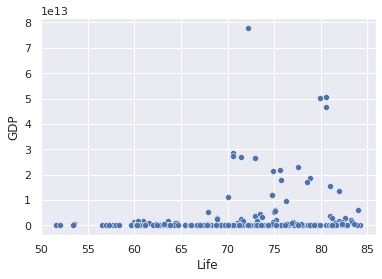

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= twothousand_sixteen_df)

(0.0, 100.0)

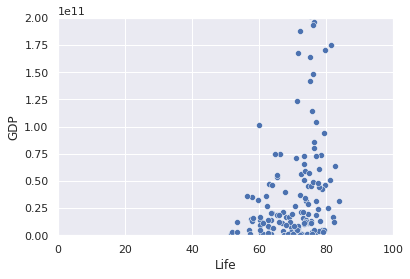

In [ ]:
sns.scatterplot(x='Life', y='GDP', data= twothousand_sixteen_df)
plt.ylim(0, 200000000000)
plt.xlim(0, 100)

Here, we see an increase in life expectancy over the years, but we also see a massive increase in the higher-ups in the GDP scale, with the highest going from about 3.5 in 1990, all the way up to the highest being about 8 in 2016. As our math earlier suggests, there is likely a strong positive correlation between GDP and life expectancy.

# Takeaways

The two biggest takeaways from this analysis are that there is strong evidence to support the claim that there is a positive correlation between the access to electricity and the GDP of a country, with the life expectancy of a country. This being said, there is little evidence to support the claim that the number of health workers per capita has an impact on life expectancy. Given this information, it would be a safe inference to say that the top priority concerning increasing life expectancy for a country should be developing industry and infrastructure, as these have both been shown to correlate to life expectancy.